# Version 3 : LightAutoML
# Version 6 : Neural Network 

Refrence notebook - https://www.kaggle.com/pourchot/simple-neural-network

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import log_loss

import gc
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations,callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import initializers

from keras.models import Model

In [2]:
train = pd.read_csv('../input/tabular-playground-series-jun-2021/train.csv')
test = pd.read_csv("../input/tabular-playground-series-jun-2021/test.csv")
submission = pd.read_csv("../input/tabular-playground-series-jun-2021/sample_submission.csv")
submission = submission.set_index('id')

# EDA

In [3]:
train.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,target
0,0,0,0,6,1,0,0,0,0,7,...,0,0,0,0,0,0,2,0,0,Class_6
1,1,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,1,0,Class_6
2,2,0,0,0,0,0,1,0,3,0,...,0,0,0,0,1,0,0,0,0,Class_2
3,3,0,0,7,0,1,5,2,2,0,...,0,4,0,2,2,0,4,3,0,Class_8
4,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Class_2


# Checking null values

In [4]:
print(f'Number of rows: {train.shape[0]};  Number of columns: {train.shape[1]}; No of missing values: {sum(train.isna().sum())}')

Number of rows: 200000;  Number of columns: 77; No of missing values: 0


In [5]:
print(f'Number of rows: {test.shape[0]};  Number of columns: {test.shape[1]}; No of missing values: {sum(test.isna().sum())}')

Number of rows: 100000;  Number of columns: 76; No of missing values: 0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 77 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          200000 non-null  int64 
 1   feature_0   200000 non-null  int64 
 2   feature_1   200000 non-null  int64 
 3   feature_2   200000 non-null  int64 
 4   feature_3   200000 non-null  int64 
 5   feature_4   200000 non-null  int64 
 6   feature_5   200000 non-null  int64 
 7   feature_6   200000 non-null  int64 
 8   feature_7   200000 non-null  int64 
 9   feature_8   200000 non-null  int64 
 10  feature_9   200000 non-null  int64 
 11  feature_10  200000 non-null  int64 
 12  feature_11  200000 non-null  int64 
 13  feature_12  200000 non-null  int64 
 14  feature_13  200000 non-null  int64 
 15  feature_14  200000 non-null  int64 
 16  feature_15  200000 non-null  int64 
 17  feature_16  200000 non-null  int64 
 18  feature_17  200000 non-null  int64 
 19  feature_18  200000 non-

In [7]:
train.describe()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,200000.000000
mean,99999.500000,0.972710,1.168365,2.219325,2.296735,0.793530,1.431105,1.010695,0.673090,1.94398,...,1.798040,0.508695,1.827300,0.910370,1.603585,1.219210,0.806895,1.282925,2.94021,0.632005
std,57735.171256,3.941836,3.993407,6.476570,7.551858,2.935785,5.162746,3.949231,2.234949,3.93133,...,5.053014,1.867330,7.188924,3.835182,4.877679,4.826003,2.458741,4.261420,10.78465,3.925310
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,49999.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,99999.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,149999.250000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.00000,...,1.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.00000,0.000000
max,199999.000000,61.000000,51.000000,64.000000,70.000000,38.000000,76.000000,43.000000,30.000000,38.00000,...,54.000000,24.000000,79.000000,55.000000,65.000000,67.000000,30.000000,61.000000,130.00000,52.000000


# Target Distribution

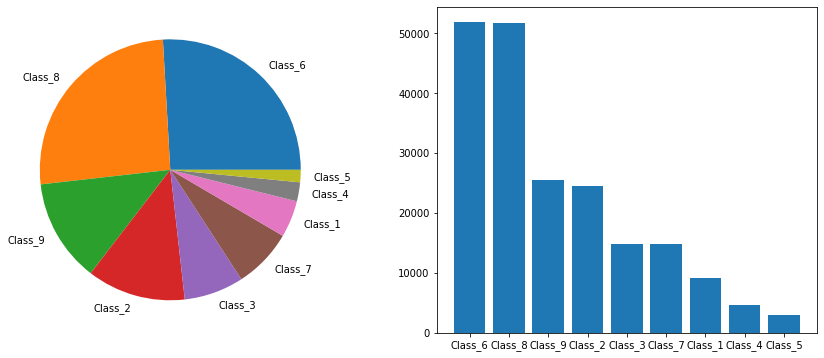

In [8]:
target_mass = train['target'].value_counts()
values = target_mass.values.tolist()
indexes = target_mass.index.tolist()

ax,fig = plt.subplots(1,2,figsize=(15,6))
plt.subplot(1,2,1)
plt.pie(values , labels = indexes)
plt.subplot(1,2,2)
plt.bar(indexes,values)
plt.show()

# Correlation

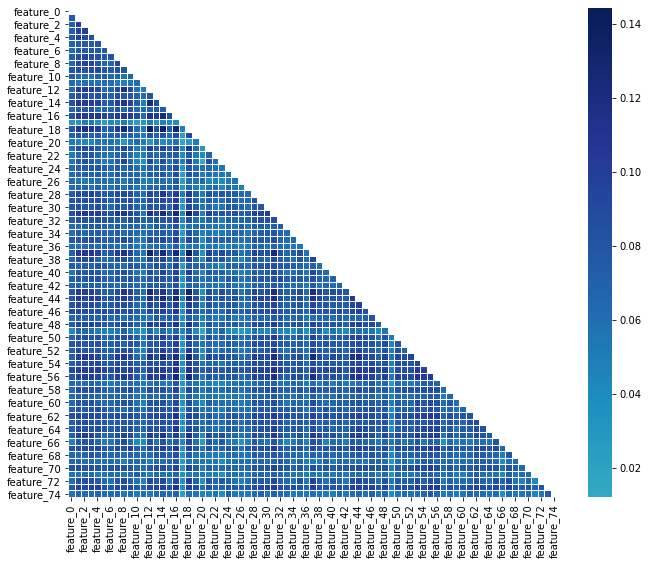

In [9]:
fet_set = train.drop(labels=['id','target'],axis=1)
def plot_diag_heatmap(data):
    corr = data.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(11, 9))
    sns.heatmap(corr, mask=mask, cmap='YlGnBu', center=0,square=True, linewidths=1, cbar_kws={"shrink": 1.0})
plot_diag_heatmap(fet_set)

In [10]:
train1 = pd.read_csv('../input/tabular-playground-series-jun-2021/train.csv', index_col = 'id')
test1 = pd.read_csv('../input/tabular-playground-series-jun-2021/test.csv', index_col = 'id')
x_cols = train1.columns[0:-1].tolist()
y_col = train1.columns[-1]

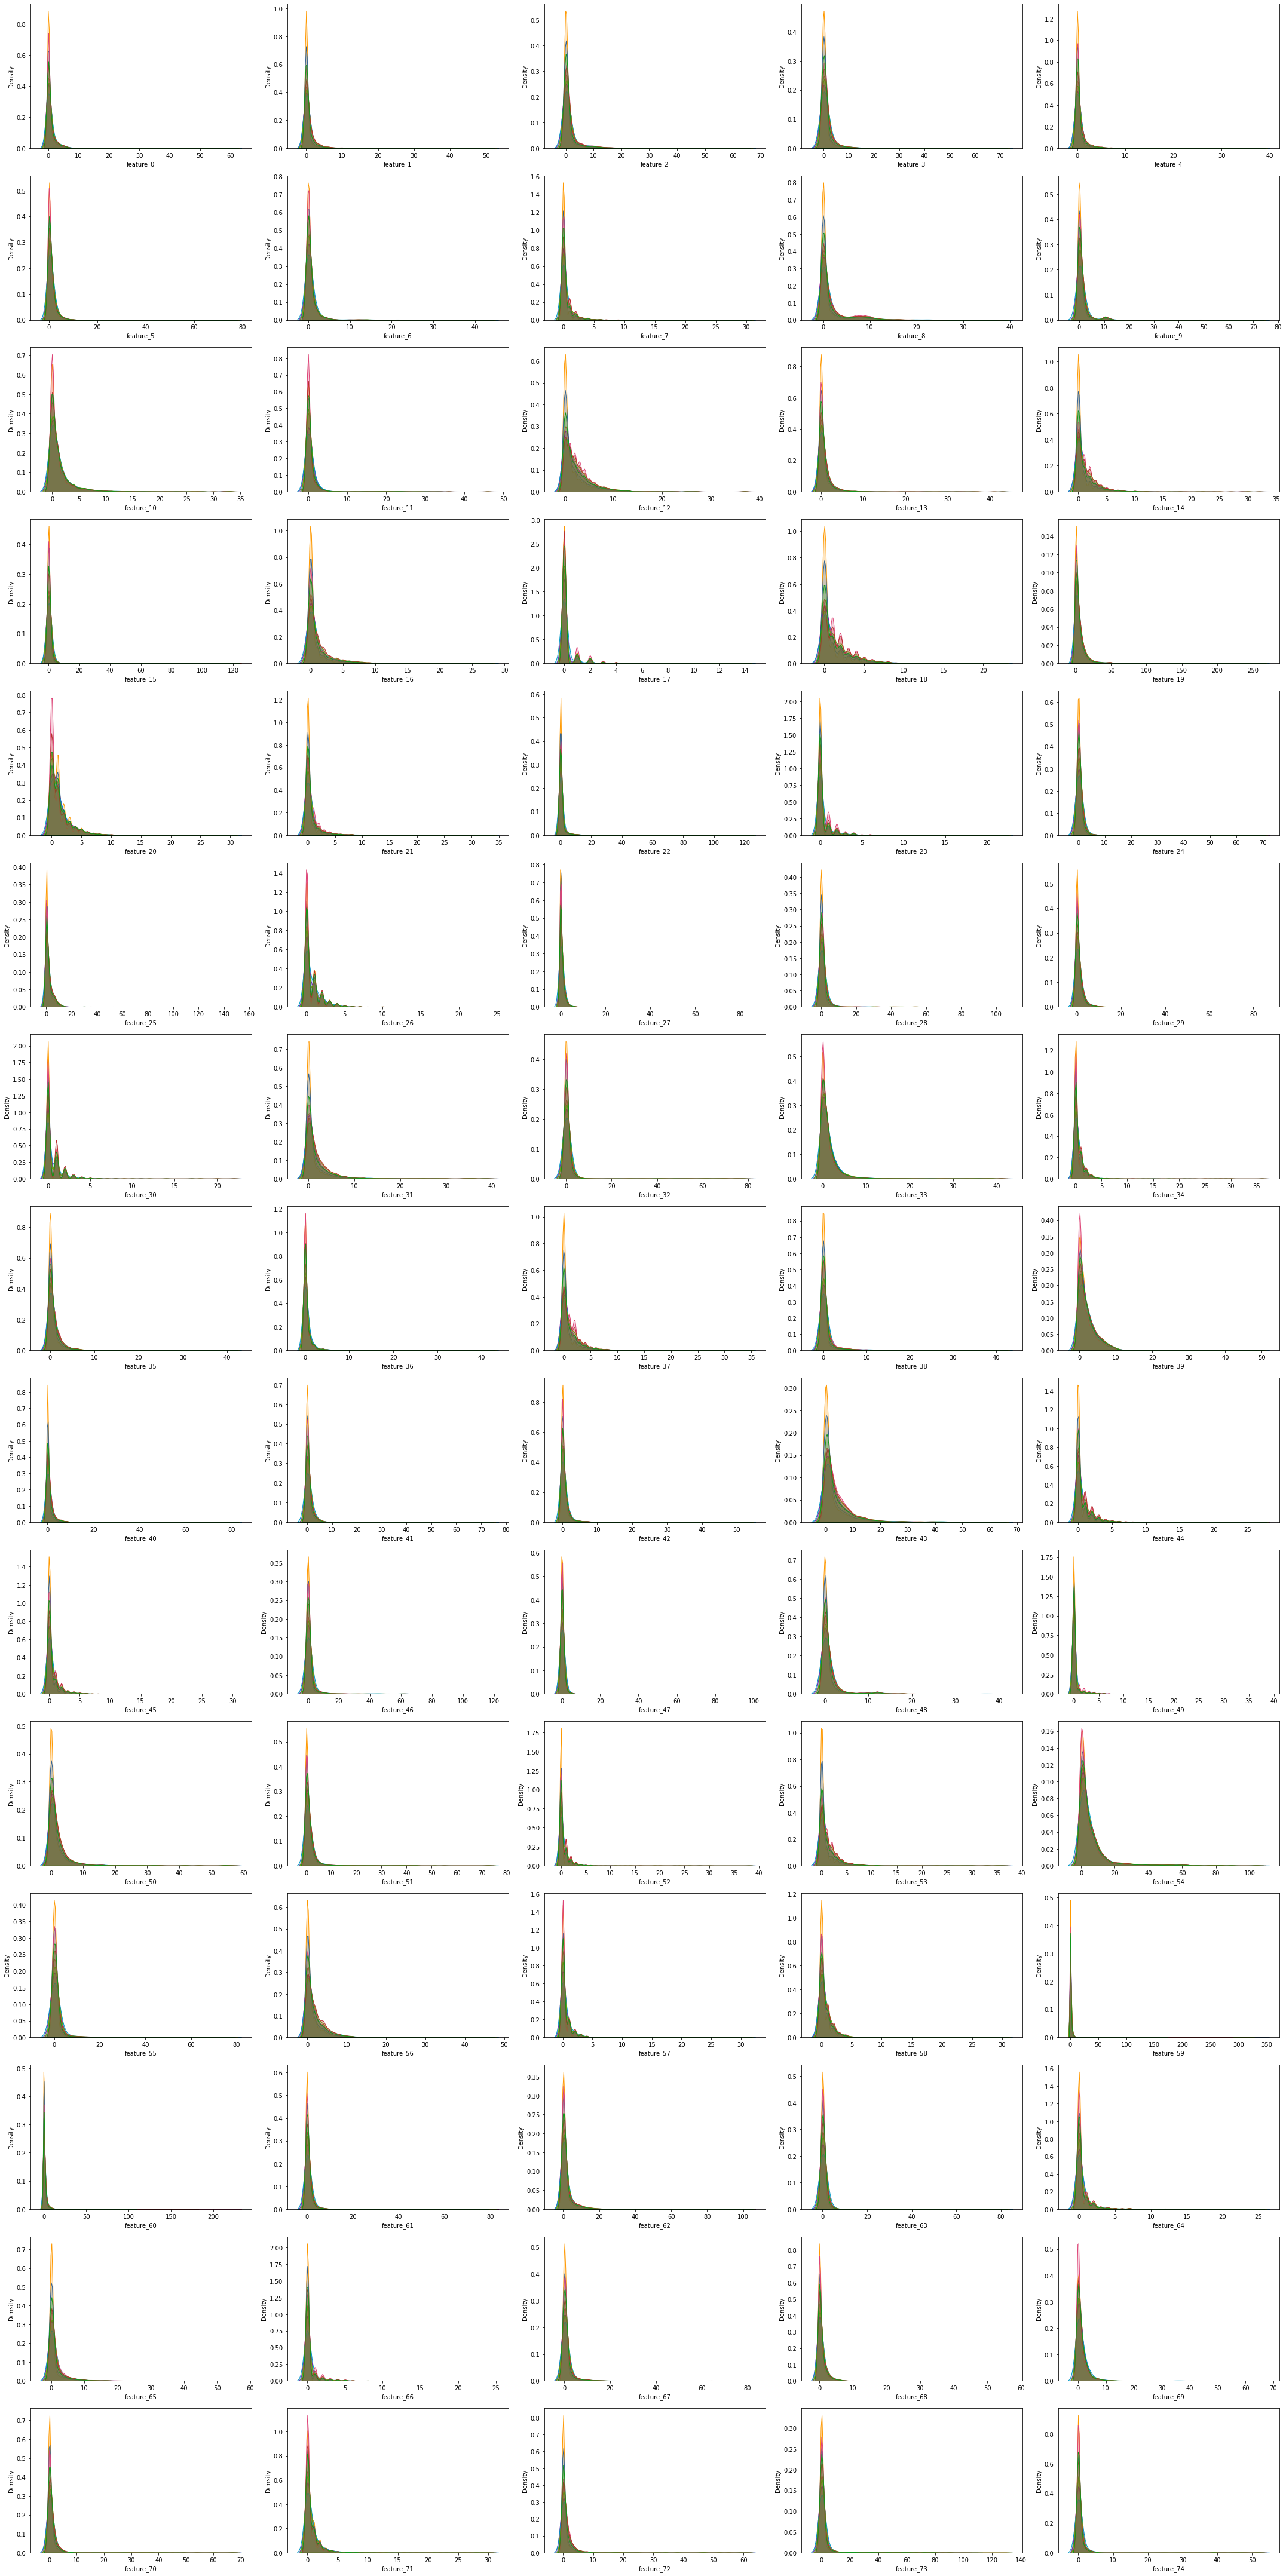

In [11]:
import plotly.express as px

target_column = 'target'
num_rows, num_cols = 15,5
f, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(30, 60))

for index, column in enumerate(x_cols):
    i,j = (index // num_cols, index % num_cols)

    sns.kdeplot(train1.loc[train1[target_column] == 'Class_1', column], color=px.colors.qualitative.G10[1], shade=True, ax=axes[i,j])
    sns.kdeplot(train1.loc[train1[target_column] == 'Class_2', column], color=px.colors.qualitative.G10[2], shade=True, ax=axes[i,j])
    sns.kdeplot(train1.loc[train1[target_column] == 'Class_3', column], color=px.colors.qualitative.G10[9], shade=True, ax=axes[i,j])
    sns.kdeplot(train1.loc[train1[target_column] == 'Class_4', column], color=px.colors.qualitative.G10[4], shade=True, ax=axes[i,j])
    sns.kdeplot(train1.loc[train1[target_column] == 'Class_5', column], color=px.colors.qualitative.G10[5], shade=True, ax=axes[i,j])
    sns.kdeplot(train1.loc[train1[target_column] == 'Class_6', column], color=px.colors.qualitative.G10[6], shade=True, ax=axes[i,j])
    sns.kdeplot(train1.loc[train1[target_column] == 'Class_7', column], color=px.colors.qualitative.G10[7], shade=True, ax=axes[i,j])
    sns.kdeplot(train1.loc[train1[target_column] == 'Class_8', column], color=px.colors.qualitative.G10[8], shade=True, ax=axes[i,j])
    sns.kdeplot(train1.loc[train1[target_column] == 'Class_9', column], color=px.colors.qualitative.G10[3], shade=True, ax=axes[i,j])
plt.tight_layout()
plt.show()

In [12]:
targets = pd.get_dummies(train['target'])

In [13]:
def custom_metric(y_true, y_pred):
    y_pred = K.clip(y_pred, 1e-15, 1-1e-15)
    loss = K.mean(cce(y_true, y_pred))
    return loss

cce = tf.keras.losses.CategoricalCrossentropy()

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_custom_metric', min_delta=1e-05, patience=5, verbose=0,
    mode='min', baseline=None, restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_custom_metric', factor=0.7, patience=2, verbose=0,
    mode='min')

In [14]:
def conv_model():

    conv_inputs = layers.Input(shape = (75))
    embed = layers.Embedding (input_dim = 354, 
                              output_dim = 7,
                              embeddings_regularizer='l2')(conv_inputs)
    embed = layers.Conv1D(12,1,activation = 'relu')(embed)        
    embed = layers.Flatten()(embed)
    hidden = layers.Dropout(0.3)(embed)
    
    hidden = tfa.layers.WeightNormalization(
                layers.Dense(
                units=32,
                activation ='selu',
                kernel_initializer = "lecun_normal"))(hidden)
    
    output = layers.Dropout(0.3)(layers.Concatenate()([embed, hidden]))
    output = tfa.layers.WeightNormalization(
    layers.Dense(
                units = 32,
                activation='relu',
                kernel_initializer = "lecun_normal"))(output) 
    output = layers.Dropout(0.4)(layers.Concatenate()([embed, hidden, output]))
    output = tfa.layers.WeightNormalization(
    layers.Dense(
                units = 32, 
                activation = 'relu',
                kernel_initializer = "lecun_normal"))(output)
    
    conv_outputs = layers.Dense(
                units = 9, 
                activation ='softmax',
                kernel_initializer ="lecun_normal")(output)
    
    model = Model(conv_inputs,conv_outputs)
    
    return model

In [15]:
oof_NN_a = np.zeros((train.shape[0],9))
pred_NN_a = np.zeros((test.shape[0],9))

N_FOLDS = 25
SEED = 2021
EPOCH = 60


skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for fold, (tr_idx, ts_idx) in enumerate(skf.split(train,train.iloc[:,-1])):
    print(f"\n ====== TRAINING FOLD {fold} =======\n")

    X_train = train.iloc[:,1:-1].iloc[tr_idx]
    y_train = targets.iloc[tr_idx]
    X_test = train.iloc[:,1:-1].iloc[ts_idx]
    y_test = targets.iloc[ts_idx]

    K.clear_session()
    
    print("\n-----Convolution model Training----\n")

    model_conv = conv_model()

    model_conv.compile(loss='categorical_crossentropy', 
                            optimizer = keras.optimizers.Adam(learning_rate=2e-4), 
                            metrics=custom_metric)
    model_conv.fit(X_train, y_train,
              batch_size = 256, epochs = EPOCH,
              validation_data=(X_test, y_test),
              callbacks=[es, plateau],
              verbose = 0)
   
    pred_a = model_conv.predict(X_test) 
    oof_NN_a[ts_idx] += pred_a 
    score_NN_a = log_loss(y_test, pred_a)
    print(f"\nFOLD {fold} Score convolution model: {score_NN_a}\n")
    pred_NN_a += model_conv.predict(test.iloc[:,1:]) / N_FOLDS 
 
score_a = log_loss(targets, oof_NN_a)
print(f"\n=== FINAL SCORE CONVOLUTION MODEL : {score_a}===\n")


 ====== TRAINING FOLD 0 =======


-----Convolution model Training----


FOLD 0 Score convolution model: 1.7441874878229573


 ====== TRAINING FOLD 1 =======


-----Convolution model Training----


FOLD 1 Score convolution model: 1.7370941865579226


 ====== TRAINING FOLD 2 =======


-----Convolution model Training----


FOLD 2 Score convolution model: 1.743095995802898


 ====== TRAINING FOLD 3 =======


-----Convolution model Training----


FOLD 3 Score convolution model: 1.732674987750128


 ====== TRAINING FOLD 4 =======


-----Convolution model Training----


FOLD 4 Score convolution model: 1.7386015752013773


 ====== TRAINING FOLD 5 =======


-----Convolution model Training----


FOLD 5 Score convolution model: 1.740740412031999


 ====== TRAINING FOLD 6 =======


-----Convolution model Training----


FOLD 6 Score convolution model: 1.7417269569905476


 ====== TRAINING FOLD 7 =======


-----Convolution model Training----


FOLD 7 Score convolution model: 1.746244457717985


 ==

In [16]:
pred_embedding = pred_NN_a

In [17]:
submission = pd.read_csv("../input/tabular-playground-series-jun-2021/sample_submission.csv")
submission['Class_1']=pred_embedding[:,0]
submission['Class_2']=pred_embedding[:,1]
submission['Class_3']=pred_embedding[:,2]
submission['Class_4']=pred_embedding[:,3]
submission['Class_5']=pred_embedding[:,4]
submission['Class_6']=pred_embedding[:,5]
submission['Class_7']=pred_embedding[:,6]
submission['Class_8']=pred_embedding[:,7]
submission['Class_9']=pred_embedding[:,8]

In [18]:
submission.to_csv("Sol.csv", index=False)